# 概要
検索したい二次流通のURLを記入してRunすると、以下の3つを出力します
1. ['イベント名','詳細','価格','販売数','取引中、取引前などのstatus']という情報を持つテーブルデータ
2. イベントごとの二次流通価格に関する箱ひげ図
3. イベントごとの二次流通量を示す棒グラフ

# 使用者がすべきこと
- base_urlを指定するだけ
- （例：base_url = 'https://ticketjam.jp/tickets/gamba-osaka'）

### base_url

In [1]:
base_url = 'https://ticketjam.jp/tickets/gamba-osaka'

### import

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt

### def

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# スクレイピングのmain
def scrape(page_url):
    
    # 404エラーを防ぐためheadersを追加
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    eventlist_items = soup.find_all(class_=['eventlist__item active','eventlist__item bg-gray'])
    
    # 空のデータを作成
    events = []
    details = []
    prices = []
    amounts = []
    status_box = []
    
    # eventlist__items内の要素ごとにループ処理
    for item in eventlist_items:

        # Event name
        event = item.find('div', class_='eventlist__title')
        if event:
            # Remove the small tags
            for small in event.find_all('small'):
                small.decompose()
            event_text = event.get_text(separator=' ', strip=True)
            events.append(event_text)
        else:
            events.append(None)
    
        # Event detail
        detail = item.find('div', class_='eventlist__description')
        if detail:
            detail_text = detail.get_text(separator=' ', strip=True)
            details.append(detail_text)
        else:
            details.append(None)
        
        # Event price
        price = item.find('span', class_='u-text-vivid-red u-text-size-md font-weight-bold')
        if price:
            price_text = price.get_text(strip=True)
            prices.append(price_text)
        else:
            prices.append(None)
        
        # Event amount
        amount = item.find('span', class_=['ml-1 bold sell-true', 'ml-1 bold'])
        if amount:
            amount_text = amount.get_text(strip=True)
            amounts.append(amount_text)
        else:
            amounts.append(None)

        # Event status
        status_section = item.find('div', class_='eventlist__links')
        if status_section:
            status = status_section.find('span', class_='u-text-vivid-red')
            if status:
                status_text = status.get_text(strip=True)
                if status_text in ['取引中', '取引済']:
                    status_box.append(status_text)
                else:
                    status_box.append('取引前')
            else:
                status_box.append('取引前')
        else:
            status_box.append('取引前')

    # 取得したデータを用いてデータフレームを作成
    df = pd.DataFrame({
        'events': events,
        'details': details,
        'prices': prices,
        'amounts': amounts,
        'status': status_box
    })

    df['prices'] = df['prices'].str.replace(',', '').astype(int)
    df['amounts'] = df['amounts'].apply(extract_numbers)
    
    return df, soup

# event_detailsからまとまったグループに分類
def convert(df):
    df2 = df.copy()
    df2 = df2[['events','description','prices','amounts','status']]
    return df2

# 枚数を変換するコード
def extract_numbers(text):
    match = re.search(r'\d+', text)
    return int(match.group()) if match else None

### prepare

In [4]:
all_dfs = []

# 最初のページからスタート
page_url = base_url
while page_url:
    df, soup = scrape(page_url)
    if df is not None:
        all_dfs.append(df)
    
    # 次ページに遷移
    next_page_element = soup.find('a', rel='next')
    if next_page_element and 'href' in next_page_element.attrs:
        next_page_url = next_page_element['href']
        page_url = "https://ticketjam.jp" + next_page_url
    else:
        page_url = None

# 取得したすべてのデータを結合
final_df = pd.concat(all_dfs, ignore_index=True)
final_df = final_df.rename(columns={'details':'description'})

In [5]:
# データを綺麗な形に変換
final_df2 = convert(final_df)
final_df2

,events,description,prices,amounts,status
0,ガンバ大阪 vs FC東京,[詳細]\nカテゴリー６指定席小中高 下層Ｂ６ブロックパナソニック Ｊリーグアプリより購入\...,800,4,取引前
1,ガンバ大阪 vs FC東京,[詳細]\nカテゴリー６ 自由席 自由席２枚ありますが、１枚だけの購入でも結構です。入金が確...,1500,2,取引前
2,柏レイソル vs ガンバ大阪,[詳細]\n柏熱地帯 立見自由席 セブンイレブンにて発券となります。,3000,3,取引前
3,ガンバ大阪 vs アビスパ福岡,[詳細]\nカテゴリー6 上層自由席 ファンクラブ招待で友人用に買いましたが、都合が悪くなっ...,3500,1,取引前
4,ガンバ大阪 vs FC東京,[詳細]\nカテゴリー2、C-11、21列5〜10番。QRコードチケットの譲渡になります。,3500,1,取引前
...,...,...,...,...,...
160,Real Sociedad Japan Tour 2024,,12000,1,取引中
161,セレッソ大阪 vs ガンバ大阪,,12000,2,取引中
162,Real Sociedad Japan Tour 2024,,16980,1,取引中
163,セレッソ大阪 vs ガンバ大阪,,17000,1,取引中


In [6]:
final_df2.to_csv('soccer_tickets_scraping.csv',index=False,encoding="shift_jis",errors="ignore")

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'ガンバ大阪 vs FC東京'),
  Text(1, 0, '柏レイソル vs ガンバ大阪'),
  Text(2, 0, 'ガンバ大阪 vs アビスパ福岡'),
  Text(3, 0, 'セレッソ大阪 vs ガンバ大阪'),
  Text(4, 0, 'ヴィッセル神戸 vs ガンバ大阪'),
  Text(5, 0, 'Real Sociedad Japan Tour 2024')])

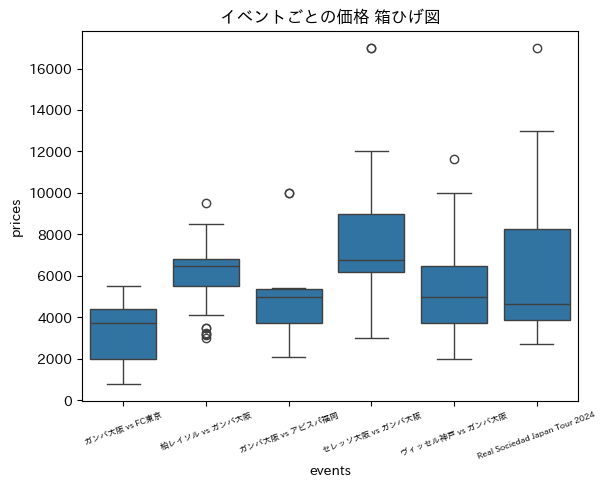

In [7]:
sns.boxplot(data=final_df2,x='events',y='prices')
plt.title('イベントごとの価格 箱ひげ図')
plt.xticks(rotation=20, fontsize=6)

C:\Users\kyuza\AppData\Local\Temp\ipykernel_22204\1375409235.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for_vis = for_vis.groupby('events').sum().reset_index()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Real Sociedad Japan Tour 2024'),
  Text(1, 0, 'ガンバ大阪 vs FC東京'),
  Text(2, 0, 'ガンバ大阪 vs アビスパ福岡'),
  Text(3, 0, 'セレッソ大阪 vs ガンバ大阪'),
  Text(4, 0, 'ヴィッセル神戸 vs ガンバ大阪'),
  Text(5, 0, '柏レイソル vs ガンバ大阪')])

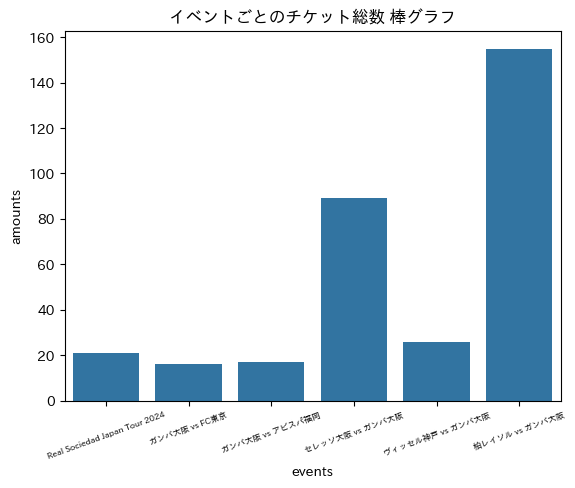

In [8]:
for_vis = final_df2.copy()
for_vis = for_vis.groupby('events').sum().reset_index()
sns.barplot(data=for_vis,x='events',y='amounts')
plt.title('イベントごとのチケット総数 棒グラフ')
plt.xticks(rotation=20, fontsize=6)

### App

In [12]:
%%writefile soccer_secondary_price_app.py


# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import japanize_matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import aiohttp
import asyncio
import streamlit as st

# 枚数を変換するコード
def extract_numbers(text):
    match = re.search(r'\d+', text)
    return int(match.group()) if match else None

# スクレイピングのmain
def scrape(team):

    base_url = f'https://ticketjam.jp/tickets/{team}'

    data_get_date = datetime.today().strftime('%Y%m%d')

    # 空のデータを作成
    events = []
    details = []
    prices = []
    amounts = []
    status_box = []
    
    # 404エラーを防ぐためheadersを追加
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    page_num = 1

    while True:
        if page_num = 1:
            page_url = f'{base_url}'
        else:
            page_url = f'{base_url}?page={page_num}'

        response = requests.get(page_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        eventlist_items = soup.find_all(class_=['eventlist__item active','eventlist__item bg-gray'])
        
        # eventlist__items内の要素ごとにループ処理
        for item in eventlist_items:

            # Event name
            event = item.find('div', class_='eventlist__title')
            if event:
                # Remove the small tags
                for small in event.find_all('small'):
                    small.decompose()
                event_text = event.get_text(separator=' ', strip=True)
                events.append(event_text)
            else:
                events.append(None)
        
            # Event detail
            detail = item.find('div', class_='eventlist__description')
            if detail:
                detail_text = detail.get_text(separator=' ', strip=True)
                details.append(detail_text)
            else:
                details.append(None)
            
            # Event price
            price = item.find('span', class_='u-text-vivid-red u-text-size-md font-weight-bold')
            if price:
                price_text = price.get_text(strip=True)
                prices.append(price_text)
            else:
                prices.append(None)
            
            # Event amount
            amount = item.find('span', class_=['ml-1 bold sell-true', 'ml-1 bold'])
            if amount:
                amount_text = amount.get_text(strip=True)
                amounts.append(amount_text)
            else:
                amounts.append(None)

            # Event status
            status_section = item.find('div', class_='eventlist__links')
            if status_section:
                status = status_section.find('span', class_='u-text-vivid-red')
                if status:
                    status_text = status.get_text(strip=True)
                    if status_text in ['取引中', '取引済']:
                        status_box.append(status_text)
                    else:
                        status_box.append('取引前')
                else:
                    status_box.append('取引前')
            else:
                status_box.append('取引前')

        # 次のページがあるか確認しなければ終了
        next_page_element = soup.find('a', rel='next')
        if next_page_element and 'href' in next_page_element.attrs:
            page_num += 1
        else:
            break

        time.sleep(0.1)

    # 取得したデータを用いてデータフレームを作成
    df = pd.DataFrame({
        'data_get_date' : data_get_date,
        'events': events,
        'details': details,
        'prices': prices,
        'amounts': amounts,
        'status': status_box
    })

    df['prices'] = df['prices'].str.replace(',', '').astype(int)
    df['amounts'] = df['amounts'].apply(extract_numbers)
    
    return df

st.title('サッカー 二次流通市場価格 スクレイピング アプリ')

st.markdown("<hr>", unsafe_allow_html=True)

st.markdown("""
### このアプリについて

チケジャムから以下の情報を取得します：

- `data_get_dates`: 今日の日付
- `events`: 試合概要
- `details`: チケットに関する説明
- `prices`: チケット価格
- `amounts`: チケット枚数
- `status`: 取引状況
""")

st.markdown("<hr>", unsafe_allow_html=True)

teams_display = {
    'サッカー日本代表': 'national-team-soccer',
    '明治安田生命J1リーグ': 'meijiyasudaseimei-ji',
    '明治安田生命J2リーグ': 'meijiyasudaseimei-j2',
    'アビスパ福岡': 'avispa',
    'アルビレックス新潟': 'albirex',
    '浦和レッズ': 'reds',
    'ヴィッセル神戸': 'vissel-kobe',
    'FC東京': 'fctokyo',
    'FC町田ゼルビア': 'zelvia',
    'ガンバ大阪': 'gamba-osaka',
    '川崎フロンターレ': 'frontale',
    '鹿島アントラーズ': 'antlers',
    '柏レイソル': 'reysol',
    '京都サンガFC': 'sanga-fc',
    '湘南ベルマーレ': 'bellmare',
    'サガン鳥栖': 'sagan-tosu',
    'サンフレッチェ広島': 'sanfrecce',
    'セレッソ大阪': 'cerezo',
    'ジュビロ磐田': 'jubilo-iwata',
    '東京ヴェルディ': 'verdy',
    '北海道コンサドーレ札幌': 'consadole-sapporo',
    '名古屋グランパス': 'nagoya-grampus',
    '横浜F・マリノス': 'f-marinos'
}

selected_teams_display = st.multiselect('チームを選択してください', teams_display.keys(), default=None)

all_selected = st.checkbox('全てのチームをスクレイピング')

if all_selected:
    selected_teams_display = list(teams_display.keys())

if st.button('スクレイピング開始'):
    all_dfs = []
    with st.spinner('スクレイピング中'):
        for selected_team_display in selected_teams_display:
            df = scrape(selected_team_display)
            all_dfs.append(df)
        combined_df = pd.concat(all_dfs, ignore_index=True)
        st.write('スクレイピング完了')
        st.dataframe(combined_df)
        csv = combined_df.to_csv(index=False)
        st.download_button(
            label='CSVとしてダウンロード',
            data=csv,
            file_name=f'combined_routes_{datetime.today().strftime("%Y%m%d")}.csv',
            mime='text/csv'
        )

Overwriting soccer_secondary_price_app.py


In [13]:
!echo | streamlit run soccer_secondary_price_app.py


      Welcome to Streamlit!

      If you’d like to receive helpful onboarding emails, news, offers, promotions,
      and the occasional swag, please enter your email address below. Otherwise,
      leave this field blank.

      Email:  


2024-07-29 11:16:20.435 'utf-8' codec can't decode byte 0x82 in position 5: invalid start byte
